Using device: cuda
Found 10 log files in C://Users/park9/ModernTCN_Physics/data/MHEALTHDATASET
Loaded MHEALTH dataset
  X shape : (5361, 128, 23)  (N, T, C)
  y shape : (5361,)  (N,)
  Classes : 12
Total combined size: 5361 samples

New random split (80/20):
  New Train set: 4288 samples
  New Test set:  1073 samples

Normalization stats (mean, std) computed from new train split.
  - Parameters: 76,251
Parameters      : 0.0763 M
FLOPs / sample : 8.965 M
Infer Time     : 3.09 ms/sample
[Physics*] Epoch 025/150 | Train Acc=99.93% | CE=0.3027 | Phys=0.4523 (λ_total=0.100) | Total=0.3479 || Test F1=0.9873 | Test Acc=98.70% (Best F1=0.9881, Best Acc=98.79%)
[Physics*] Epoch 050/150 | Train Acc=100.00% | CE=0.2992 | Phys=0.4393 (λ_total=0.100) | Total=0.3431 || Test F1=0.9897 | Test Acc=98.97% (Best F1=0.9906, Best Acc=99.07%)
[Physics*] Epoch 075/150 | Train Acc=100.00% | CE=0.2979 | Phys=0.3440 (λ_total=0.100) | Total=0.3323 || Test F1=0.9876 | Test Acc=98.79% (Best F1=0.9915, Best Acc=99.

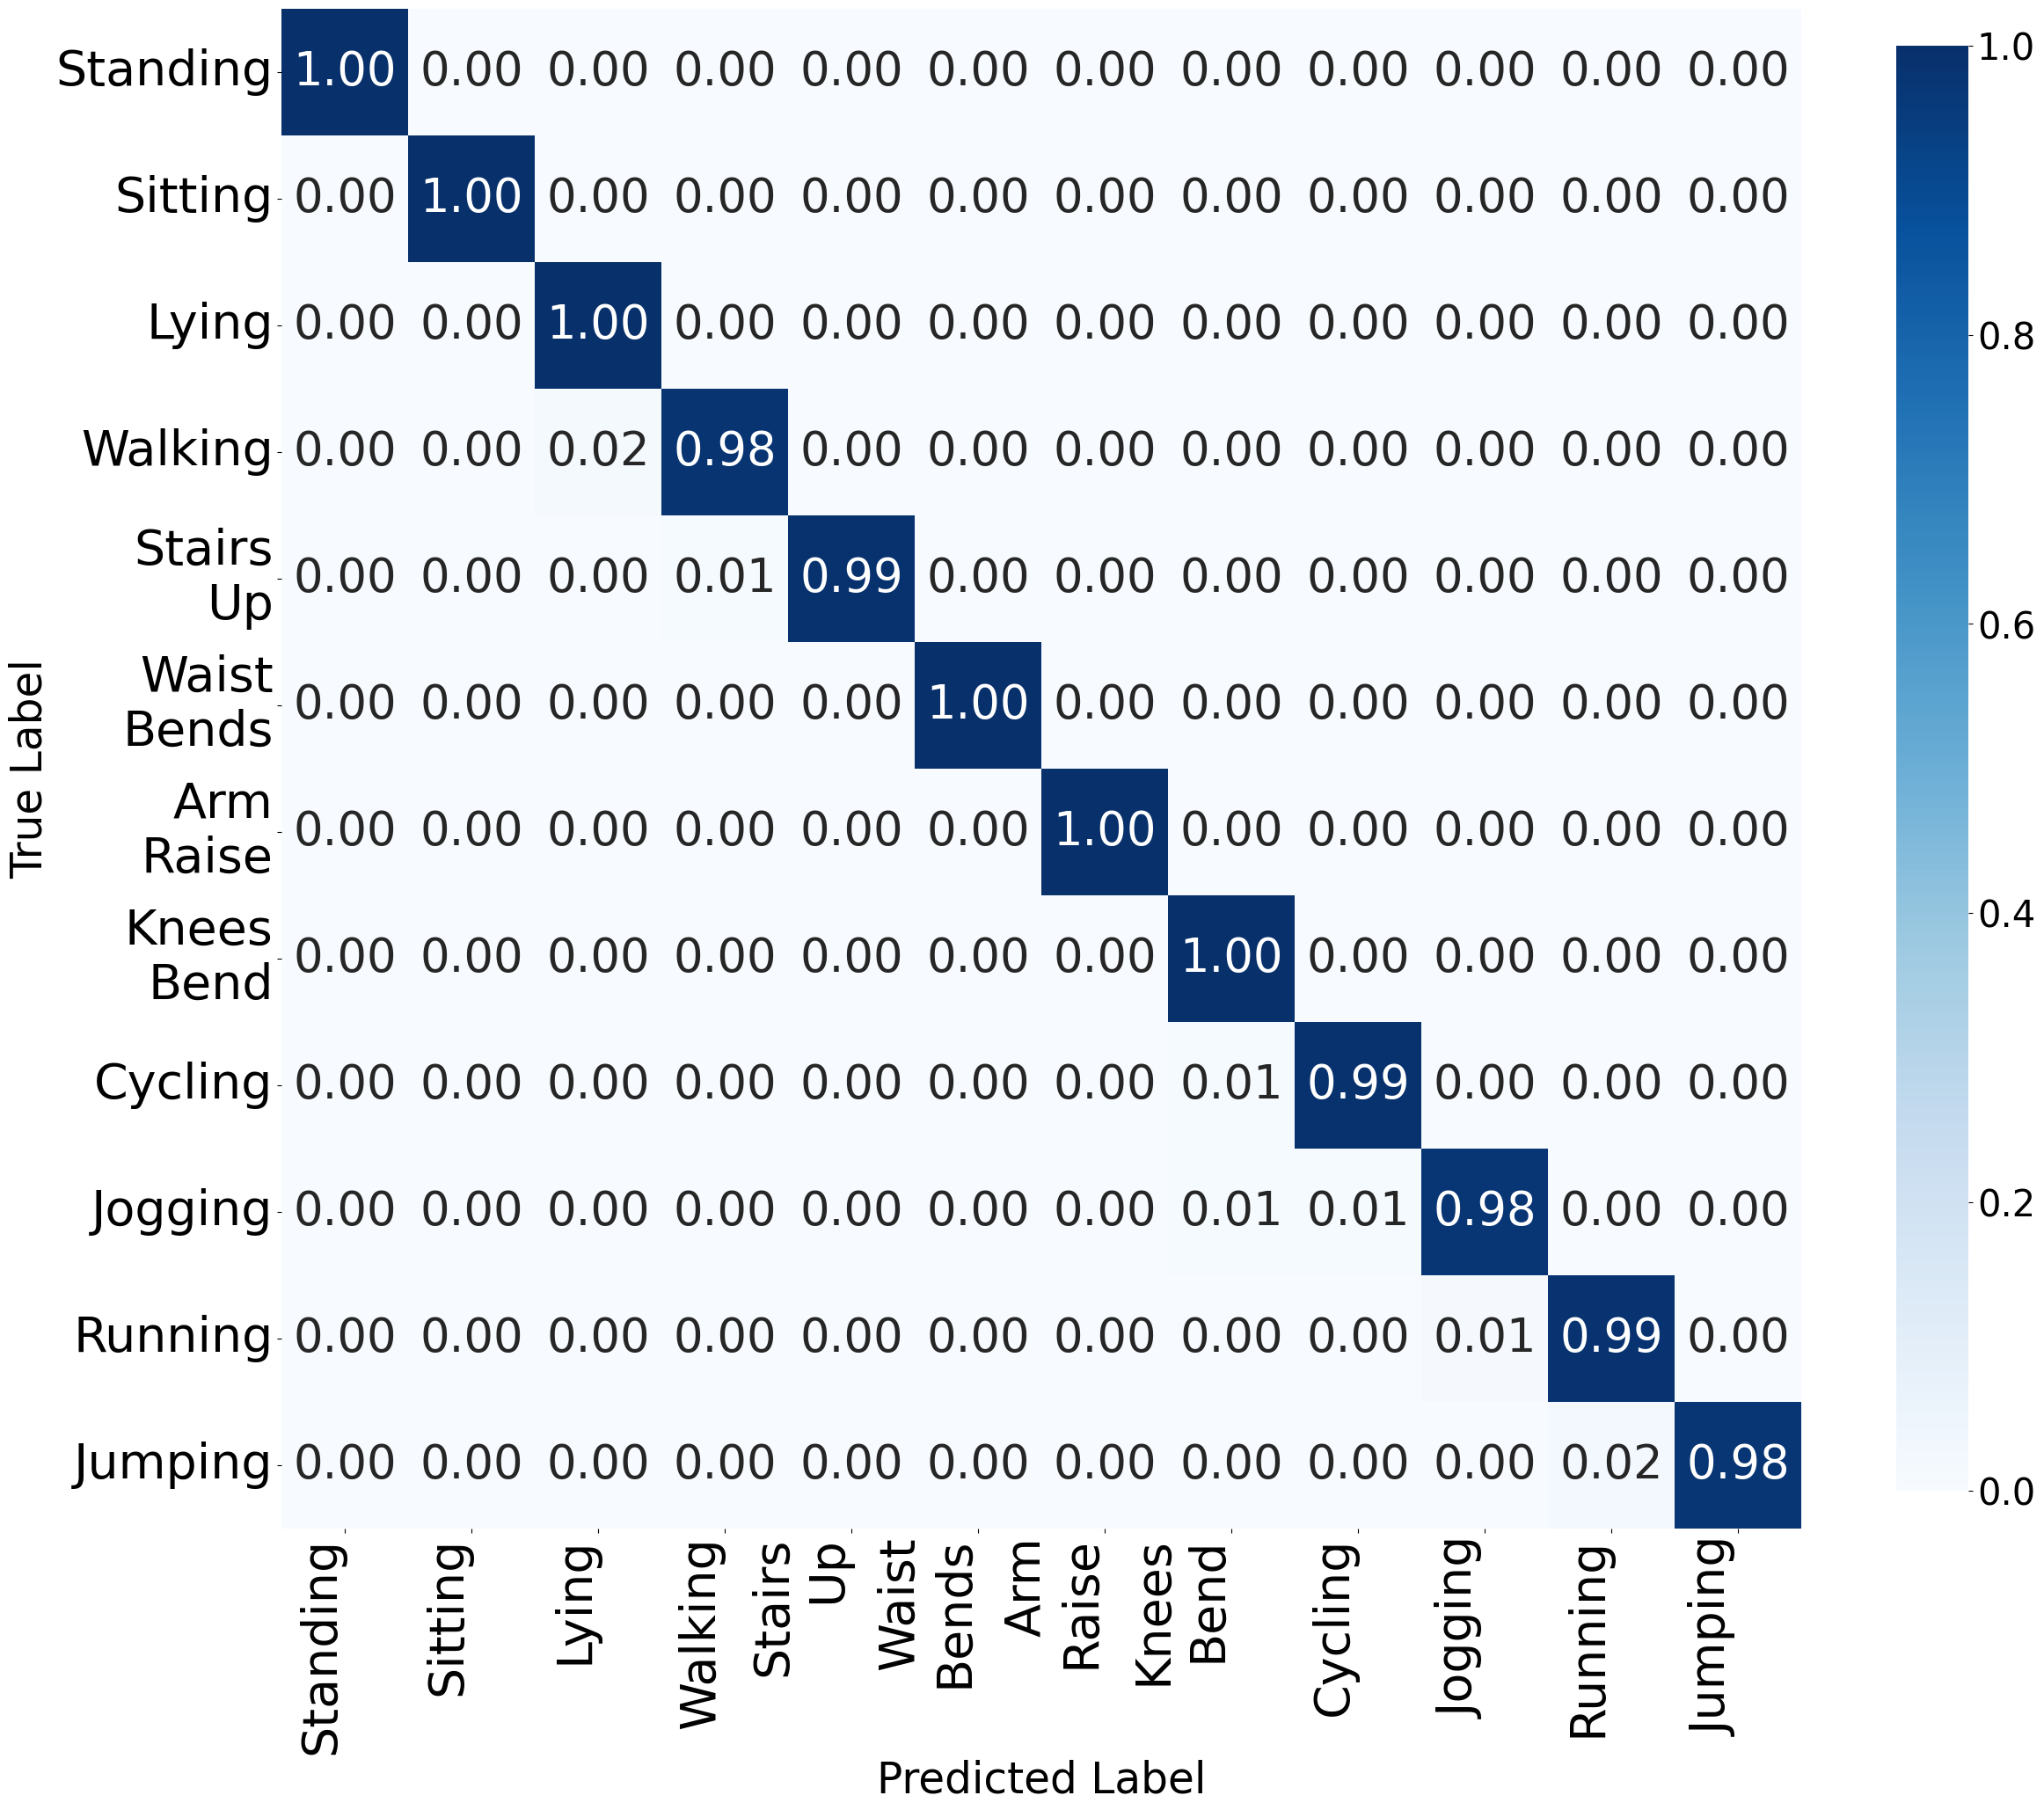

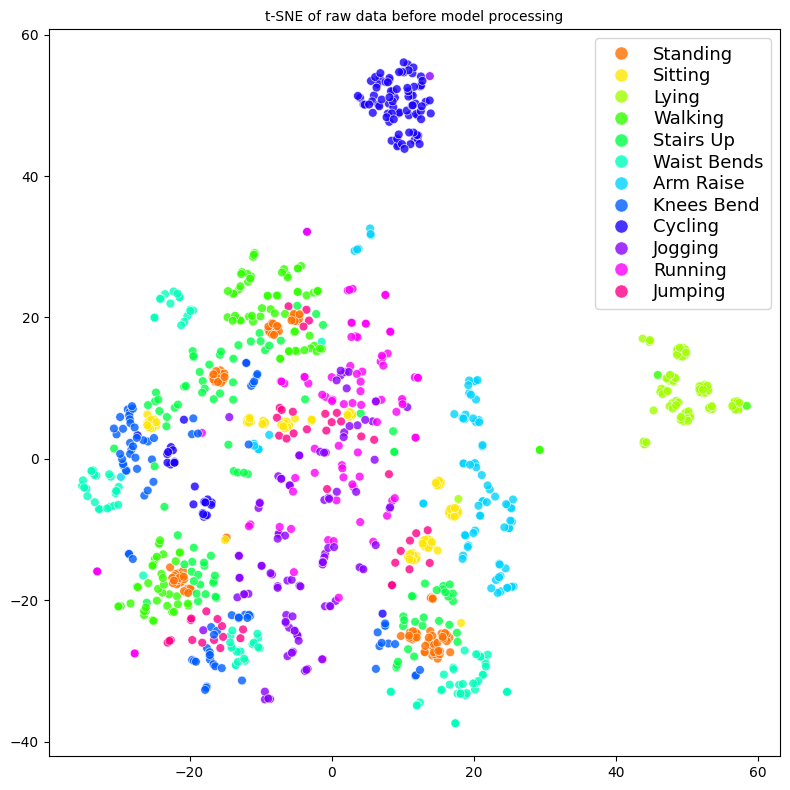


Running t-SNE on 1073 points (Perplexity=30)...


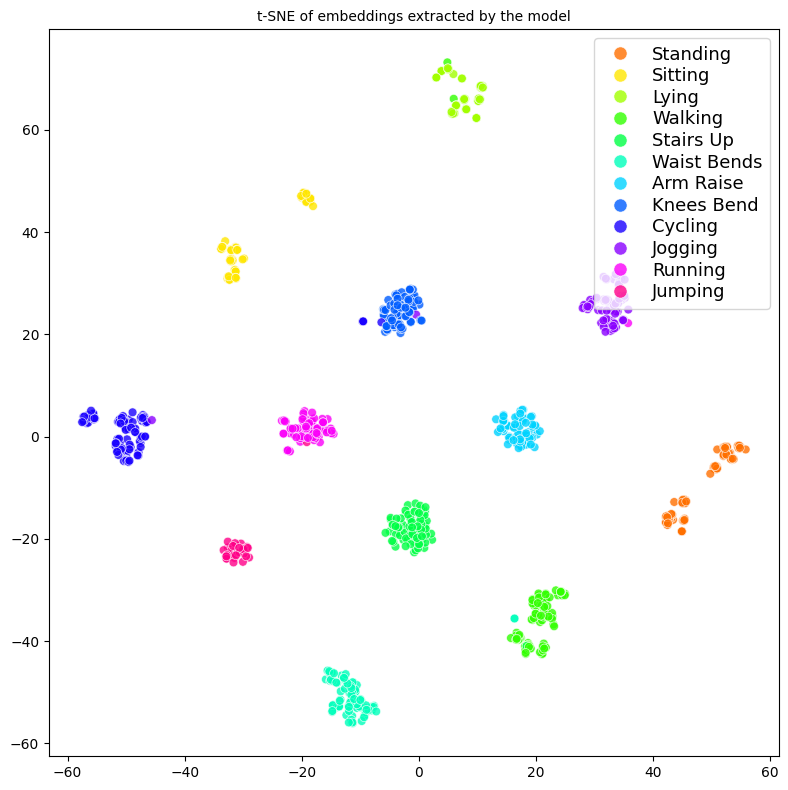

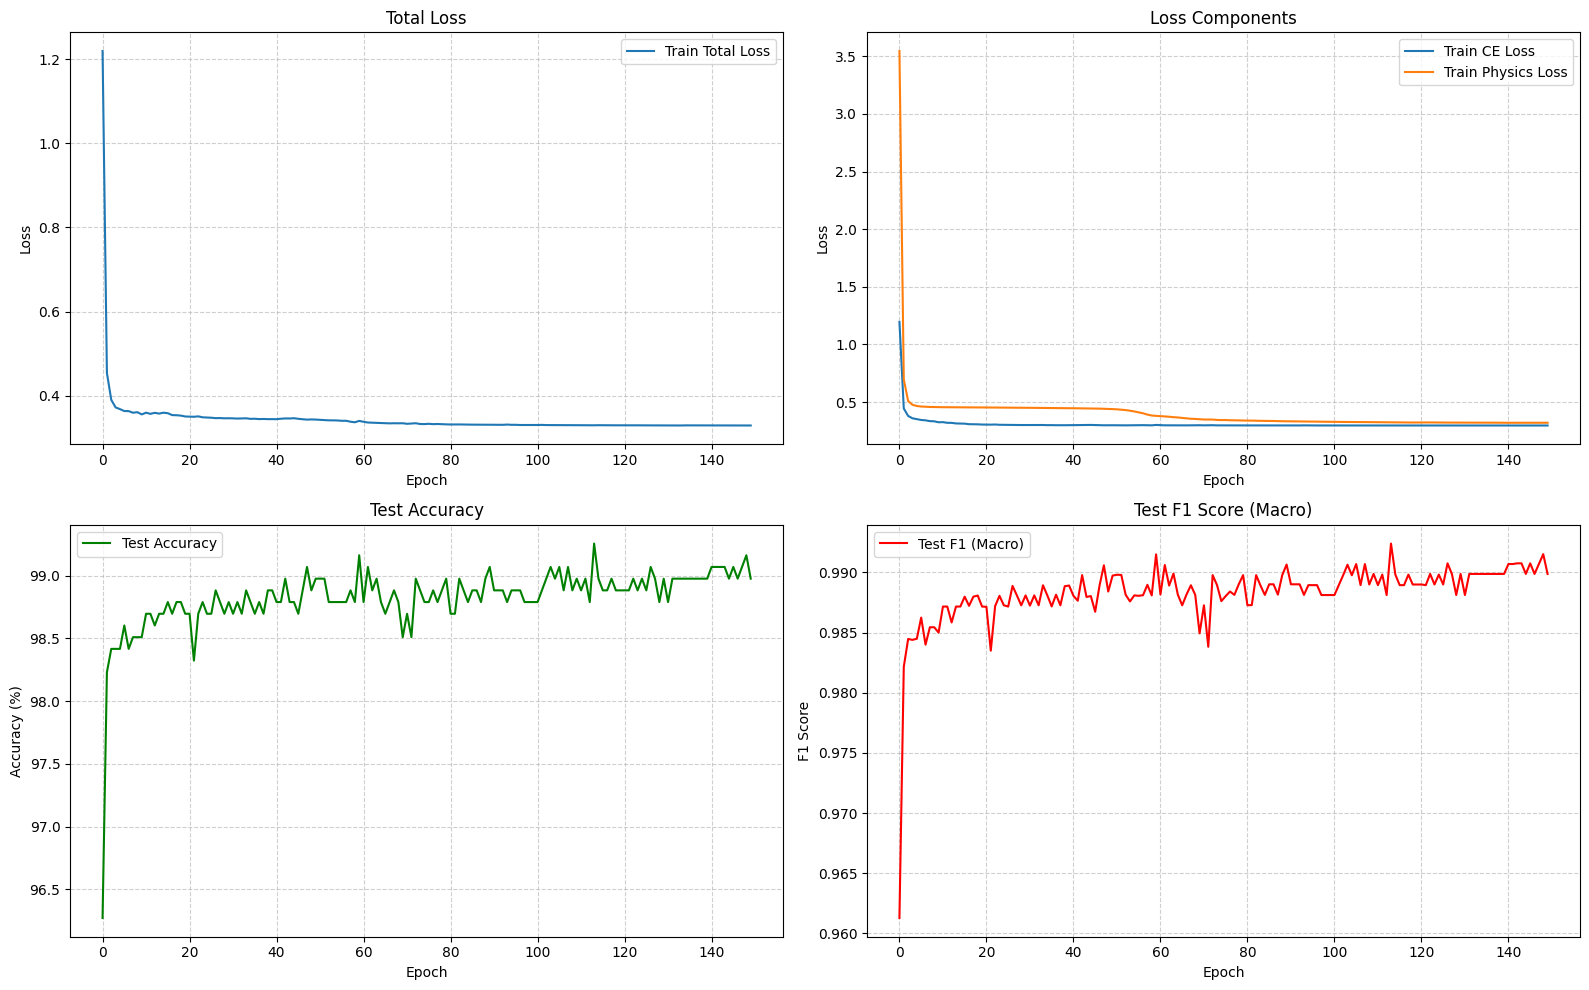

In [1]:
import os
import io
import time
import glob
import random
import contextlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt    

from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix, classification_report    

try:
    from fvcore.nn import FlopCountAnalysis
    FVCORE_AVAILABLE = True
except ImportError:
    FlopCountAnalysis = None
    FVCORE_AVAILABLE = False

# ========================
# SEED 고정 함수
# ========================
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA 11+

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True, warn_only=False)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

# ========================
# MHEALTH 데이터 로드 
# ========================
def _load_single_mhealth_log(path: str, feature_cols: list[str]):
    """
    하나의 mHealth_subjectXX.log 파일을 로드해서 DataFrame으로 반환.
    """
    df = pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=feature_cols + ["label"],
    )
    return df

def load_mhealth_dataframe(data_dir: str):
    """
    data_dir 안의 mHealth_subject*.log 전부 읽어서 하나의 DataFrame으로 concat.
    """
    feature_cols = [
        "acc_chest_x", "acc_chest_y", "acc_chest_z",      # 0, 1, 2
        "ecg_1", "ecg_2",                                 # 3, 4
        "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",      # 5, 6, 7  <- Physics
        "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",   # 8, 9, 10 <- Physics
        "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",      # 11, 12, 13
        "acc_arm_x", "acc_arm_y", "acc_arm_z",          # 14, 15, 16
        "gyro_arm_x", "gyro_arm_y", "gyro_arm_z",       # 17, 18, 19
        "mag_arm_x", "mag_arm_y", "mag_arm_z",          # 20, 21, 22
    ]  # 총 23 channels

    log_files = glob.glob(os.path.join(data_dir, "mHealth_subject*.log"))
    if not log_files:
         raise FileNotFoundError(f"No mHealth_subject*.log files found in {data_dir}")
    print(f"Found {len(log_files)} log files in {data_dir}")

    dfs = []
    for fp in log_files:
        df_i = _load_single_mhealth_log(fp, feature_cols)
        dfs.append(df_i)

    full_df = pd.concat(dfs, ignore_index=True)

    # Null 클래스(label==0)는 제외
    full_df = full_df[full_df["label"] != 0].copy()

    # 원래 라벨 1~12 → 0~11 로 shift
    full_df.loc[:, "label"] = full_df["label"] - 1

    return full_df, feature_cols

def create_mhealth_windows(
    df: pd.DataFrame,
    feature_cols: list[str],
    window_size: int,
    step_size: int,
):
    """
    전체 시계열을 (window_size, step_size)로 슬라이딩하면서 윈도우 생성.
    반환:
        X_np : (N, C, T) float32  <- (채널, 시간)
        y_np : (N,) int64         <- 0~11 로 이미 shift된 라벨
    """
    data_arr = df[feature_cols].to_numpy(dtype=np.float32)  # (L, 23)
    labels_arr = df["label"].to_numpy(dtype=np.int64)       # (L,)
    L = data_arr.shape[0]

    X_list = []
    y_list = []

    start = 0
    while start + window_size <= L:
        end = start + window_size
        window_x = data_arr[start:end]        # (T, C)
        window_label = labels_arr[end - 1]    # 마지막 타임스텝 라벨
        window_x_ct = np.transpose(window_x, (1, 0))  # (C, T)

        X_list.append(window_x_ct)
        y_list.append(int(window_label))
        start += step_size

    if not X_list:
        raise RuntimeError("No windows created. Check window_size / step_size / dataset length.")

    X_np = np.stack(X_list, axis=0).astype(np.float32)  # (N, C, T)
    y_np = np.array(y_list, dtype=np.int64)             # (N,)
    return X_np, y_np

class MHEALTHDataset(Dataset):
    """
    MHEALTH Dataset wrapper
    - X를 (N, T, C) 형태로 저장
    - __getitem__이 (X_tc, y, s) 튜플을 반환하도록 수정
    """
    def __init__(self, data_dir: str, window_size: int = 128, step_size: int = 64):
        super().__init__()

        # 1) 로그 로드 & 전처리
        full_df, feature_cols = load_mhealth_dataframe(data_dir)

        # 2) 슬라이딩 윈도우 생성
        X, y = create_mhealth_windows(
            df=full_df,
            feature_cols=feature_cols,
            window_size=window_size,
            step_size=step_size,
        ) # X: (N, C, T), y: (N,)

        # X를 (N, T, C) 형태로 저장 (UCI-HAR와 통일)
        self.X = np.transpose(X, (0, 2, 1)).astype(np.float32)
        self.y = y
        # 더미 subject ID 추가 (collate_fn 호환용)
        self.subjects = np.zeros(len(self.y), dtype=int) # (기존 코드 호환용)

        # 라벨 이름 (0~11 인덱스 기준)
        self.label_names = [
            "Standing still", "Sitting and relaxing", "Lying down",
            "Walking", "Climbing stairs", "Waist bends forward",
            "Frontal elevation of arms", "Knees bending", "Cycling",
            "Jogging", "Running", "Jump front & back",
        ]

        print("=" * 80)
        print("Loaded MHEALTH dataset")
        print(f"  X shape : {self.X.shape}  (N, T, C)")
        print(f"  y shape : {self.y.shape}  (N,)")
        print(f"  Classes : {len(self.label_names)}")
        print("=" * 80)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx: int):
        """
        (T, C) 텐서, 라벨, 더미 서브젝트 ID 반환
        """
        return (torch.FloatTensor(self.X[idx]),       # (T, C)
                torch.LongTensor([self.y[idx]])[0], # scalar
                self.subjects[idx])                 # scalar (dummy)

# ========================
# Modern TCN Components 
# ========================
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_channels, in_channels, kernel_size,
            padding=padding, dilation=dilation, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleConvBlock(nn.Module):
    def __init__(self, channels, kernel_sizes=[3, 5, 7], dilation=1, dropout=0.1):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = ((k - 1) * dilation) // 2
            branch = nn.ModuleDict({
                'conv': DepthwiseSeparableConv1d(channels, channels, k, dilation, padding),
                'norm': nn.BatchNorm1d(channels),
                'dropout': nn.Dropout(dropout)
            })
            self.branches.append(branch)
        self.fusion = nn.Conv1d(channels * len(kernel_sizes), channels, 1)

    def forward(self, x):
        outputs = []
        target_length = x.size(2)
        for branch in self.branches:
            out = branch['conv'](x)
            if out.size(2) != target_length:
                out = out[:, :, :target_length]
            out = branch['norm'](out)
            out = F.gelu(out)
            out = branch['dropout'](out)
            outputs.append(out)
        multi_scale = torch.cat(outputs, dim=1)
        return self.fusion(multi_scale)

class ModernTCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 7], dilation=1, dropout=0.1):
        super().__init__()
        
        # NOTE: kernel_sizes가 [7]처럼 단일 리스트로 들어오면 Single-scale이 됨
        self.multi_conv1 = MultiScaleConvBlock(
            in_channels if in_channels == out_channels else out_channels,
            kernel_sizes, dilation, dropout
        )
        
        # NOTE: kernel_sizes 중 가장 큰 값을 기준으로 padding
        max_k = max(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        padding = ((max_k - 1) * dilation) // 2
        
        self.conv2 = DepthwiseSeparableConv1d(
            out_channels, out_channels, max_k, dilation, padding
        )
        self.norm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        target_length = x.size(2)
        if self.downsample is not None:
            x = self.downsample(x)
            residual = x
        
        out = self.multi_conv1(x)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        
        out = self.conv2(out)
        if out.size(2) != target_length:
            out = out[:, :, :target_length]
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout2(out)
        return F.gelu(out + residual)

class SqueezeExcitation1d(nn.Module):
    def __init__(self, channels, reduction=5):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
    def forward(self, x):
        batch, channels, _ = x.size()
        squeeze = F.adaptive_avg_pool1d(x, 1).view(batch, channels)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation)).view(batch, channels, 1)
        return x * excitation

class LargeKernelConv1d(nn.Module):
    def __init__(self, channels, kernel_size=21):
        super().__init__()
        padding = kernel_size // 2
        self.depthwise = nn.Conv1d(
            channels, channels, kernel_size,
            padding=padding, groups=channels
        )
        self.norm = nn.BatchNorm1d(channels)
    def forward(self, x):
        out = self.depthwise(x)
        out = self.norm(out)
        return out

# ========================
# Modern TCN Base 모델 
# ========================
class BaseModernTCNHAR(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, n_layers=4, n_classes=6,
                 kernel_sizes=[3, 7], large_kernel=21, dropout=0.1, use_se=True):
        super().__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, 1)
        self.large_kernel_conv = LargeKernelConv1d(hidden_dim, large_kernel)
        self.tcn_blocks = nn.ModuleList()
        for i in range(n_layers):
            dilation = 2 ** i
            self.tcn_blocks.append(
                ModernTCNBlock(
                    hidden_dim, hidden_dim,
                    kernel_sizes=kernel_sizes,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.final_large_kernel = LargeKernelConv1d(hidden_dim, large_kernel)
        # self.final_large_kernel = nn.Identity()
        self.use_se = use_se
        if use_se:
            self.se = SqueezeExcitation1d(hidden_dim)
        self.norm_final = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.input_proj(x)
        x = self.large_kernel_conv(x)
        x = F.gelu(x)
        for block in self.tcn_blocks:
            x = block(x)
        x = self.final_large_kernel(x)
        x = F.gelu(x)
        if self.use_se:
            x = self.se(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x = self.norm_final(x)
        return self.head(x)

# ========================
# Physics-Guided Modern TCN HAR 
# ========================
class PhysicsModernTCNHAR(BaseModernTCNHAR):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        hidden_dim = self.head.in_features

        self.gravity_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

    def forward(self, x, return_gravity=False):
        x = x.transpose(1, 2)
        x_feat = self.input_proj(x)
        x_feat = F.gelu(self.large_kernel_conv(x_feat))
        for block in self.tcn_blocks:
            x_feat = block(x_feat)
        x_feat = F.gelu(self.final_large_kernel(x_feat))
        if self.use_se:
            x_feat = self.se(x_feat)

        pooled = F.adaptive_avg_pool1d(x_feat, 1).squeeze(-1)
        pooled = self.norm_final(pooled)
        logits = self.head(pooled)

        outs = [logits]

        if return_gravity:
            seq_feat = x_feat.transpose(1, 2)  # (B,T,C)
            gvec = self.gravity_head(seq_feat)   # (B,T,3)
            outs.append(gvec)

        return tuple(outs) if len(outs) > 1 else outs[0]

# ========================
# '물리 손실' 함수 
# ========================
def fir_lpf_hann_bt3(x, K=31):
    """
    x: (B,T,3)  -> a_lp, a_hp (둘 다 (B,T,3))
    간단 Hann 창 평균 기반 LPF. HPF = x - LPF
    """
    assert x.dim() == 3 and x.size(-1) == 3
    B, T, C = x.shape
    xc = x.transpose(1, 2)  # (B,3,T)
    w = torch.hann_window(K, dtype=xc.dtype, device=xc.device)
    w = (w / w.sum()).view(1,1,-1).expand(C,1,-1)  # (3,1,K)
    a_lp = F.conv1d(xc, w, padding=K//2, groups=C).transpose(1, 2)
    a_hp = x - a_lp
    return a_lp, a_hp

def unit_norm(v, eps=1e-8):
    return v / (v.norm(dim=-1, keepdim=True) + eps)

def diff1(x):
    # x: (B,T,D) -> same shape with zero-pad at t=0
    d = x[:, 1:] - x[:, :-1]
    pad = torch.zeros(x.size(0), 1, x.size(2), device=x.device, dtype=x.dtype)
    return torch.cat([pad, d], dim=1)


@torch.no_grad()
def estimate_dt_from_freq(default_dt=1/50):
    # UCI-HAR≈50Hz, MHEALTH≈50Hz, WISDM≈20Hz, PAMAP2≈100Hz
    return default_dt

def physics_loss_upgraded(
    X_raw,          # (B,T,9): [:,:,:3]=acc, [:,:,3:6]=gyro
    g_pred,         # (B,T,3): gravity unit vector (모델 예측)
    lambdas,        # dict: 각 항 가중치
    params          # dict: 하이퍼파라미터(tau_w,tau_a,alpha_lp,alpha_comp,win_mean,dt,g0)
):
    acc = X_raw[:, :, 5:8]
    gyro = X_raw[:, :, 8:11]
    eps = 1e-8

    # 1) LPF로 중력후보, HPF로 동적성분
    a_lp, a_hp = fir_lpf_hann_bt3(acc, K=params.get('K', 31))
    g_from_acc = unit_norm(a_lp, eps=eps)

    # 2) 게이팅: 정적/완만 구간만 신뢰
    tau_w = params.get('tau_w', 1.0)
    tau_a = params.get('tau_a', 0.5)
    gate = ((gyro.norm(dim=-1) < tau_w) & (a_hp.norm(dim=-1) < tau_a)).float()  # (B,T)

    # 3) g_pred 정규화
    g_pred = unit_norm(g_pred, eps=eps)

    # 4) 각 항 계산
    # (a) 방향 정렬 (LPF(acc)와 정렬)
    cos_sim = (g_from_acc * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)
    L_grav = torch.acos(cos_sim).mean()

    # (b) 중력 크기 (정규화된 입력이면 g0≈1.0)
    g0 = params.get('g0', 1.0)
    L_gmag = (gate * (acc.norm(dim=-1) - g0).pow(2)).mean()

    # (c) 보완필터 잔차: g_comp vs g_pred
    alpha_c = params.get('alpha_comp', 0.97)
    dt = params.get('dt', estimate_dt_from_freq())
    g_prev = torch.roll(g_pred, shifts=1, dims=1)
    g_gyro = unit_norm(g_prev - dt * torch.cross(gyro, g_prev, dim=-1), eps=eps)
    g_acc  = unit_norm(acc, eps=eps)
    g_comp = unit_norm(alpha_c * g_gyro + (1 - alpha_c) * g_acc, eps=eps)
    L_comp = torch.acos((g_comp * g_pred).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)).mean()

    # (d) 자이로 바이어스(창 평균≈0) & (e) 스무딩(jerk/ω̇)
    win = params.get('win_mean', 16)
    gyro_m = fir_lpf_hann_bt3(gyro, K=max(3, 2* (win//2)+1))[0]  # 창 평균 대용
    L_bias = (gate * gyro_m.pow(2).sum(dim=-1)).mean()
    da = diff1(acc);  dw = diff1(gyro)
    L_smooth = (da.pow(2).sum(dim=-1) + dw.pow(2).sum(dim=-1)).mean()

    # (f) 분해 일관성: a_total = a_body + g0*ĝ → a_body 창 평균이 0 근처
    a_body = acc - g0 * g_pred
    a_body_m = fir_lpf_hann_bt3(a_body, K=max(3, 2* (win//2)+1))[0]  # 로우패스=윈도 평균
    L_split = a_body_m.norm(dim=-1).mean()

    # (g) 미분운동학: dg/dt ≈ -ω×g
    dg = diff1(g_pred) / max(dt, 1e-3)
    w_cross_g = torch.cross(gyro, g_pred, dim=-1)
    L_pinn = (dg + w_cross_g).pow(2).sum(dim=-1).mean()

    L = (
        lambdas.get('grav', 0.10)   * L_grav  +
        lambdas.get('gmag', 0.05)   * L_gmag  +
        lambdas.get('comp', 0.10)   * L_comp  +
        lambdas.get('bias', 0.02)   * L_bias  +
        lambdas.get('smooth', 0.02) * L_smooth+
        lambdas.get('split', 0.05)  * L_split +
        lambdas.get('pinn', 0.03)   * L_pinn
    )

    stats = dict(grav=L_grav.item(), gmag=L_gmag.item(), comp=L_comp.item(),
                 bias=L_bias.item(), smooth=L_smooth.item(),
                 split=L_split.item(), pinn=L_pinn.item())
    return L, stats


# ========================
# 헬퍼: 파라미터 카운트
# ========================
def get_n_params(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

# ========================
# '물리 기반' 학습 함수 (F1 Score 기준)
# ========================
def train_physics(model, train_loader, test_loader, device, n_classes, epochs=50, lambda_phys=0.05, log_every=1):
    """
    lambda_phys: 총 물리손실 스케일 (각 항 상대가중치는 내부 lambdas)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # 상대 가중치 (스타팅 포인트)
    base_lambdas = dict(grav=0.15, comp=0.15, split=0.10, gmag=0.03, bias=0.01, smooth=0.01, pinn=0.05)
    # 하이퍼 (데이터 표준화/주파수에 맞게 조정)
    params = dict(
        tau_w=1.0, tau_a=0.5, alpha_comp=0.97,
        win_mean=16, dt=estimate_dt_from_freq(), g0=1.0, K=31
    )

    best_f1 = best_acc = 0.0
    history = {"train_ce": [], "train_phys": [], "train_total": [], "test_acc": [], "test_f1": []}

    warm_epochs = 15
    best_state = None
    best_eval_cache = None

    for epoch in range(1, epochs + 1):
        model.train()
        ce_sum = phys_sum = total_sum = 0.0
        correct = total = 0

        # warm-up 스케일: 초반엔 λ_phys를 선형 증가
        if epoch <= warm_epochs:
            phys_scale = lambda_phys * (epoch / warm_epochs)
        else:
            phys_scale = lambda_phys

        for X, y, _ in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            logits, gvec = model(X, return_gravity=True)
            loss_ce = F.cross_entropy(logits, y, label_smoothing=0.05)
            L_phys, stats = physics_loss_upgraded(X, g_pred=gvec, lambdas=base_lambdas, params=params)

            loss = loss_ce + phys_scale * L_phys
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            ce_sum += loss_ce.item(); phys_sum += L_phys.item(); total_sum += loss.item()
            preds = logits.argmax(1); correct += (preds == y).sum().item(); total += y.size(0)

        scheduler.step()

        n_batches = len(train_loader)
        ce_avg, phys_avg, total_avg = ce_sum/n_batches, phys_sum/n_batches, total_sum/n_batches
        train_acc = 100.0 * correct / total

        # ===== 평가 =====
        model.eval()
        test_correct = test_total = 0
        all_preds, all_y = [], []
        all_feats = []

        with torch.inference_mode():
            for X, y, _ in test_loader:
                X, y = X.to(device), y.to(device)

                feats = model.input_proj(X.transpose(1, 2))
                feats = model.large_kernel_conv(feats)
                feats = F.gelu(feats)
                for block in model.tcn_blocks:
                    feats = block(feats)
                feats = model.final_large_kernel(feats)
                feats = F.gelu(feats)
                if model.use_se:
                    feats = model.se(feats)
                pooled = F.adaptive_avg_pool1d(feats, 1).squeeze(-1)
                pooled = model.norm_final(pooled)

                logits = model.head(pooled)
                preds = logits.argmax(1)

                test_correct += (preds == y).sum().item()
                test_total   += y.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_y.extend(y.cpu().numpy())
                all_feats.append(pooled.cpu().numpy())

        test_acc = 100.0 * test_correct / test_total
        test_f1 = f1_score(all_y, all_preds, labels=list(range(n_classes)), average='macro', zero_division=0)
        best_acc = max(best_acc, test_acc)

        if test_f1 > best_f1 + 1e-9:
            best_f1 = test_f1
            best_acc = max(best_acc, test_acc)
            # CPU 텐서로 깊은 복사
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            # 베스트 시점 캐시 저장
            best_eval_cache = {
                "y":     np.array(all_y, dtype=np.int64),
                "preds": np.array(all_preds, dtype=np.int64),
                "feats": np.concatenate(all_feats, axis=0)  # (N, D)
            }

        history["train_ce"].append(ce_avg); history["train_phys"].append(phys_avg)
        history["train_total"].append(total_avg); history["test_acc"].append(test_acc); history["test_f1"].append(test_f1)

        if (epoch % log_every) == 0:
            print(f"[Physics*] Epoch {epoch:03d}/{epochs} | Train Acc={train_acc:.2f}% | "
                  f"CE={ce_avg:.4f} | Phys={phys_avg:.4f} (λ_total={phys_scale:.3f}) | "
                  f"Total={total_avg:.4f} || Test F1={test_f1:.4f} | Test Acc={test_acc:.2f}% "
                  f"(Best F1={best_f1:.4f}, Best Acc={best_acc:.2f}%)")

    return best_f1, best_acc, history, best_state, best_eval_cache  


# ========================
# 시각화 함수
# ========================
ACTIVITY_LABELS = [
    "Standing", "Sitting", "Lying",
    "Walking", "Stairs Up", "Waist Bends",
    "Arm Raise", "Knees Bend", "Cycling",
    "Jogging", "Running", "Jumping",
]

# Confusion Matrix용 (줄바꿈)
ACTIVITY_LABELS_CM = [name.replace(" ", "\n") for name in ACTIVITY_LABELS]

n_labels = len(ACTIVITY_LABELS)
hsv_colors = sns.color_palette("hsv", n_colors=n_labels)
ACTIVITY_COLOR_MAP = dict(zip(ACTIVITY_LABELS, hsv_colors))

def plot_classification_results(y_true, y_pred, save_path=None):
    """
    Confusion Matrix 시각화 
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVITY_LABELS,
            digits=4,
            zero_division=0,
        )
    )

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
                annot_kws={"size": 38}, cbar_kws={"shrink": 0.7},
                xticklabels=ACTIVITY_LABELS_CM, yticklabels=ACTIVITY_LABELS_CM)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)

    plt.xlabel('Predicted Label', fontsize=35)
    plt.ylabel('True Label', fontsize=35)
    plt.title('')
    plt.xticks(rotation=90, ha='right', fontsize=40)
    plt.yticks(rotation=0, fontsize=40)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, dpi=600)

    plt.show()
    plt.close()


def _extract_featvec_before_classifier(model, xb, device):
    """
    model.forward()의 흐름을 그대로 따라가되
    classifier 직전의 feature vector(feat_vec, shape (B, embed_dim))만 추출.
    이건 visualize_tsne에서 feature space로 쓸 거임.

    xb: (B, C_in, T) on CPU
    returns: (B, embed_dim) on CPU (no grad)
    """
    xb = xb.to(device)

    # 1. Embedding (+CBAM)
    x = model.embedding(xb)                  # (B, embed_dim, T)
    if model.use_cbam:
        x = model.cbam(x)                    # (B, embed_dim, T)

    # 2. 준비: (B, C, T) -> (B, T, C)
    x = x.transpose(1, 2).contiguous()       # (B, T, embed_dim)

    # 3. Dim reduction (optional)
    if model.use_dim_reduction:
        x = model.dim_reduce(x)              # (B, T, reduced_dim)

    # 4. Attention backbone
    if model.use_crossformer:
        # contrast 안 쓸 거라 proto_features 필요 없음
        # eval 시에는 실제 inference 경로로 skip_cross_attention=False 가 더 정직
        x = model.crossformer(
            x,
            return_proto_features=False,
            skip_cross_attention=False
        )                                    # (B, T, working_dim)
    else:
        # fallback self-attention
        x = model.self_attn(x)               # (B, T, working_dim)

    # 5. Dim restore (optional)
    if model.use_dim_reduction:
        x = model.dim_restore(x)             # (B, T, embed_dim)

    # 6. Pooling과 동일하게 처리
    # (B, T, embed_dim) -> (B, embed_dim, T)
    x = x.transpose(1, 2).contiguous()       # (B, embed_dim, T)
    feat_vec = model.pool(x).squeeze(-1)     # (B, embed_dim)

    return feat_vec.detach().cpu()           # CPU로 반환, grad 없이

def plot_tsne_from_cached_features(feats, labels, save_path=None, max_points=2000):
    """
    train_physics에서 저장한 best_eval["feats"]와 best_eval["y"]를
    받아서 t-SNE로 시각화합니다.
    """
    all_features = feats  # (N, D)
    all_labels = labels    # (N,)

    # 샘플 수 줄이기
    N = all_features.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_features[idx]  # (M, D)
    y_sel = all_labels[idx]    # (M,)

    # perplexity는 (샘플 수 - 1)보다 작아야 함
    effective_perp = min(30, len(X_sel) - 1)
    effective_perp = max(effective_perp, 5)

    print(f"\nRunning t-SNE on {len(X_sel)} points (Perplexity={effective_perp})...")

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_sel)  # (M, 2)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40,
    )
    plt.title("t-SNE of embeddings extracted by the model", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150)

    plt.show()
    plt.close()

def visualize_tsne_raw(dataloader, save_path=None, max_points=2000):
    """
    모델을 거치기 전의 raw window (shape: B x C x T)를 flatten해서 t-SNE로 투영.

    - dataloader: 보통 val_loader나 test_loader 넣는 걸 추천 (train 넣으면 class 간경계 너무 깨끗하게 나오는 경우 많음)
    - max_points: t-SNE에 사용할 최대 샘플 수
    """
    all_raw = []
    all_labels = []

    for xb, yb, _ in dataloader:
        all_raw.append(xb.cpu().numpy())     # (B, C, T)
        all_labels.append(yb.cpu().numpy())  # (B,)

    all_raw = np.concatenate(all_raw, axis=0)       # (N, C, T)
    all_labels = np.concatenate(all_labels, axis=0) # (N,)

    # 샘플 수 줄이기
    N = all_raw.shape[0]
    idx = np.arange(N)
    if N > max_points:
        idx = np.random.choice(N, size=max_points, replace=False)

    X_sel = all_raw[idx]    # (M, C, T)
    y_sel = all_labels[idx] # (M,)

    # flatten: (M, C*T)
    X_flat = X_sel.reshape(X_sel.shape[0], -1)

    effective_perp = min(30, len(X_flat) - 1)
    effective_perp = max(effective_perp, 5)

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=effective_perp,
        max_iter=2000,
        init="pca",
        learning_rate="auto",
    )
    proj = tsne.fit_transform(X_flat)

    df = pd.DataFrame(proj, columns=["Dim1", "Dim2"])
    df["label"] = [ACTIVITY_LABELS[l] for l in y_sel]

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(
        data=df,
        x="Dim1",
        y="Dim2",
        hue="label",
        palette=ACTIVITY_COLOR_MAP,
        hue_order=ACTIVITY_LABELS,
        legend="full",
        alpha=0.8,
        s=40, 
    )
    plt.title("t-SNE of raw data before model processing", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.legend(
        loc="upper right",
        fontsize=13,
        labelspacing=0.2,
        markerscale=1.5
    )
    plt.grid(False)
    plt.tight_layout()

    if save_path is not None:
        pdf_save_path = save_path
        plt.savefig(pdf_save_path, bbox_inches="tight")

    plt.show()
    plt.close()


def plot_history(history, save_path=None):
    """
    train_physics에서 반환된 history 딕셔너리를 시각화합니다.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Total Loss
    axes[0, 0].plot(history['train_total'], label='Train Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Loss Components
    axes[0, 1].plot(history['train_ce'], label='Train CE Loss')
    axes[0, 1].plot(history['train_phys'], label='Train Physics Loss')
    axes[0, 1].set_title('Loss Components')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Test Accuracy
    axes[1, 0].plot(history['test_acc'], label='Test Accuracy', color='green')
    axes[1, 0].set_title('Test Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Test F1 Score
    axes[1, 1].plot(history['test_f1'], label='Test F1 (Macro)', color='red')
    axes[1, 1].set_title('Test F1 Score (Macro)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
        
    plt.show()
    plt.close()

# =================================================================================
# Model profiling: Param(M), FLOPs(M), Inference Time(ms)
# =================================================================================
def profile_model(model,
                  sample_input: torch.Tensor,
                  device: torch.device,
                  warmup: int = 10,
                  iters: int = 50):
    """
    모델 구조/비용 측정:
      - 파라미터 수 (M 단위)
      - FLOPs per sample (M 단위, fvcore 있으면)
      - 평균 추론 시간 (ms / sample)

    fvcore가 stdout/stderr에 시끄럽게 프린트하는 걸 다 먹어버린다.
    """

    model = model.to(device)
    model.eval()

    # -------------------------------------------------
    # 1) 파라미터 수
    # -------------------------------------------------
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1e6  # million params

    # -------------------------------------------------
    # 2) FLOPs 측정 (fvcore 사용 가능할 때만)
    #    - 모든 stdout/stderr을 임시 버퍼로 리다이렉트해서
    #      "Unsupported operator ..." 같은 중얼거림을 완전히 감춘다.
    # -------------------------------------------------
    flops_m = None
    if "FVCORE_AVAILABLE" in globals() and FVCORE_AVAILABLE and FlopCountAnalysis is not None:
        try:
            with torch.no_grad():
                fake_out = io.StringIO()
                fake_err = io.StringIO()
                with contextlib.redirect_stdout(fake_out), contextlib.redirect_stderr(fake_err):
                    flops = FlopCountAnalysis(model, (sample_input.to(device),))
                    total_flops = flops.total()
            flops_m = total_flops / 1e6  # to millions
        except Exception:
            flops_m = None
    else:
        flops_m = None

    # -------------------------------------------------
    # 3) 추론 시간 측정
    # -------------------------------------------------
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(iters):
            _ = model(sample_input.to(device))
        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    avg_sec = (end - start) / iters
    inference_ms = avg_sec * 1000.0

    return {
        "params_m": params_m,
        "flops_m": flops_m,
        "inference_ms": inference_ms,
    }



def print_model_profile(stats_dict):
    print("=" * 80)
    print(f"Parameters      : {stats_dict['params_m']:.4f} M")
    print(f"FLOPs / sample : {stats_dict['flops_m']:.3f} M")
    print(f"Infer Time     : {stats_dict['inference_ms']:.2f} ms/sample")
    print("=" * 80)

# ========================
# 메인 실행 함수 (Ablation Study)
# ========================
def main():
    set_seed(42) 
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # MHEALTH 설정
    data_path = 'C://Users/park9/ModernTCN_Physics/data/MHEALTHDATASET' # MHEALTH 데이터 폴더
    window_size = 128
    step_size = 64
    N_CLASSES = 12
    N_CHANNELS = 23
    EPOCHS = 150
    BATCH_SIZE = 64

    try:
        full_dataset = MHEALTHDataset(data_path, window_size=window_size, step_size=step_size)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

    total_size = len(full_dataset)
    print(f"Total combined size: {total_size} samples")

    split_ratio = 0.8 # Train 80%
    train_size = int(total_size * split_ratio)
    test_size = total_size - train_size

    indices = list(range(total_size))
    np.random.seed(42)
    np.random.shuffle(indices)

    new_train_ds = Subset(full_dataset, indices[:train_size])
    new_test_ds = Subset(full_dataset, indices[train_size:]) 
    
    print(f"\nNew random split (80/20):")
    print(f"  New Train set: {len(new_train_ds)} samples")
    print(f"  New Test set:  {len(new_test_ds)} samples\n")

    def compute_train_stats(train_subset):
        X_train = torch.from_numpy(train_subset.dataset.X[train_subset.indices]).float()
        mean = X_train.mean(dim=(0,1), keepdim=True)
        std  = X_train.std(dim=(0,1), keepdim=True).clamp_min(1e-6)
        return mean, std

    mean, std = compute_train_stats(new_train_ds)
    print("Normalization stats (mean, std) computed from new train split.")

    def collate_norm(batch):
        X, y, s = zip(*batch)
        X = torch.stack(X, dim=0).float()
        X = (X - mean) / std
        y = torch.tensor(y, dtype=torch.long)
        s = torch.tensor(s, dtype=torch.long)
        return X, y, s

    g = torch.Generator()
    g.manual_seed(42)

    train_loader = DataLoader(
        new_train_ds, batch_size=BATCH_SIZE, shuffle=True,
        generator=g, num_workers=0, drop_last=True,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    test_loader = DataLoader(
        new_test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, drop_last=False,
        pin_memory=torch.cuda.is_available(), collate_fn=collate_norm
    )
    
    EPOCHS = 150 # 공통 Epoch
    results = {} # 결과 저장 딕셔너리

    # ---
    # Full Model
    # ---
    set_seed(42)
    model = PhysicsModernTCNHAR( 
        input_dim=N_CHANNELS, # 23
        hidden_dim=64, n_layers=3, 
        n_classes=N_CLASSES, # 12
        kernel_sizes=[3, 7], large_kernel=19, 
        dropout=0.1, use_se=True
    ).to(device)
    print(f"  - Parameters: {get_n_params(model)}")

    # ========================
    # 모델 프로파일링
    # ========================
    sample_input_shape = (1, window_size, N_CHANNELS) # (1, 128, 23)
    sample_input = torch.randn(sample_input_shape).to(device)
    profile_stats = profile_model(model, sample_input, device)
    print_model_profile(profile_stats)

    # ========================
    # 모델 학습
    # ========================
    f1_3, acc_3, hist, best_state, best_eval = train_physics(model, train_loader, test_loader, device,
                                            n_classes=N_CLASSES, epochs=EPOCHS, lambda_phys=0.1, log_every=25) 
    
    # ========================
    # 결과 시각화
    # ========================
    # 1. Classification Report & Confusion Matrix (PNG 저장)
    plot_classification_results(
        best_eval["y"], 
        best_eval["preds"], 
        save_path="cm_mhealth.png" 
    )

    # 2. t-SNE (Raw Data)
    visualize_tsne_raw(
        test_loader, 
        save_path="tsne_raw_mhealth.png" 
    )

    # 3. t-SNE (Model Features) (새 함수 호출)
    plot_tsne_from_cached_features(
        best_eval["feats"],
        best_eval["y"],
        save_path="tsne_model_mhealth.png" 
    )

    # 4. 학습 이력 (새 함수 호출)
    plot_history(
        hist, 
        save_path="history_mhealth.png" 
    )

if __name__ == '__main__':
    main()